# CutMix 또는 Mixup 비교실험 하기

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.Augmentation을 적용한 데이터셋 만들기
#### 이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

In [3]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
         ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [5]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [7]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

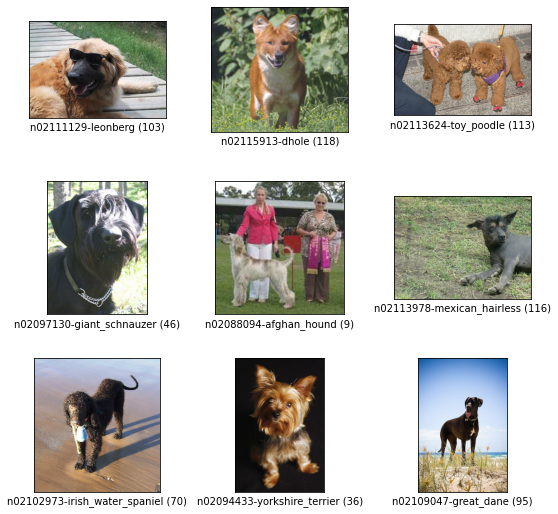

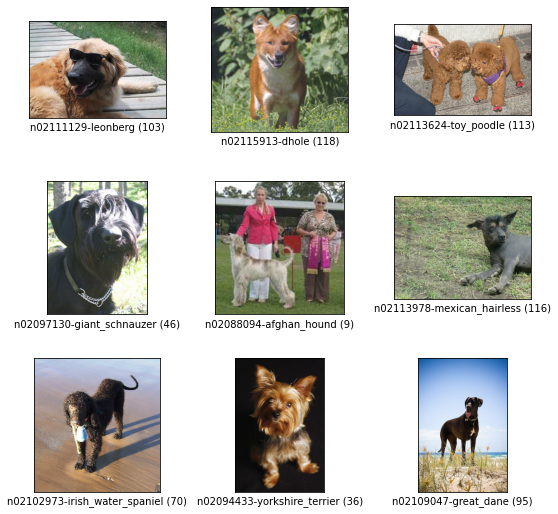

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)

 - No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋

In [9]:
num_classes = ds_info.features["label"].num_classes
batch_size = 16

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

# mixup 함수를 적용하여 데이터셋 변환
# ds_train_mixup = ds_train_aug.map(lambda image, label: mixup(image, label, batch_size=batch_size, img_size=224, num_classes=num_classes))
# cutmix 함수를 적용하여 데이터셋 변환
# ds_train_cutmix = ds_train_aug.map(lambda image, label: cutmix(image, label, batch_size=batch_size, img_size=224, num_classes=num_classes))

ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [10]:
# def example_show(dataset):
#     fig, axes = plt.subplots(3, 3, figsize=(15, 15))
#     axes = axes.ravel()
#     for images,labels in dataset.take(1):
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             ax.imshow((images[i]).numpy().astype("uint8"))
#             plt.title(labels[i])
#             plt.axis("off")
#     plt.tight_layout()
#     plt.show()

### ds_train_aug

In [11]:
# example_show(ds_train_aug)

### ds_train_mixup

In [12]:
# tfds.show_examples(ds_train_mixup, ds_info)

### ds_train_cutmix

In [13]:
# tfds.show_examples(ds_train_cutmix, ds_info)

### ds_test

In [14]:
# tfds.show_examples(ds_test, ds_info)

## 2. 모델 만들기
## 3. 모델 훈련하기

In [15]:
EPOCH = 10
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 165s 205ms/step - loss: 2.1728 - accuracy: 0.4544 - val_loss: 3.5305 - val_accuracy: 0.1831
Epoch 2/10
750/750 [==============================] - 153s 204ms/step - loss: 0.7050 - accuracy: 0.8072 - val_loss: 1.1325 - val_accuracy: 0.6660
Epoch 3/10
750/750 [==============================] - 153s 205ms/step - loss: 0.2198 - accuracy: 0.9547 - val_loss: 0.9977 - val_accuracy: 0.7093
Epoch 4/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0643 - accuracy: 0.9941 - val_loss: 0.9038 - val_accuracy: 0.7376
Epoch 5/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0300 - accuracy: 0.9983 - val_loss: 0.9105 - val_accuracy: 0.7435
Epoch 6/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0179 - accuracy: 0.9992 - val_loss: 0.9689 - val_accuracy: 0.7336
Epoch 7/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0143 - accuracy: 0.9993 - val_loss: 0.9310 -

In [16]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 161s 205ms/step - loss: 2.2649 - accuracy: 0.4328 - val_loss: 3.0589 - val_accuracy: 0.2476
Epoch 2/10
750/750 [==============================] - 153s 204ms/step - loss: 0.9594 - accuracy: 0.7273 - val_loss: 1.2008 - val_accuracy: 0.6481
Epoch 3/10
750/750 [==============================] - 153s 204ms/step - loss: 0.5171 - accuracy: 0.8568 - val_loss: 1.0171 - val_accuracy: 0.7031
Epoch 4/10
750/750 [==============================] - 153s 205ms/step - loss: 0.2763 - accuracy: 0.9317 - val_loss: 1.0460 - val_accuracy: 0.7004
Epoch 5/10
750/750 [==============================] - 153s 205ms/step - loss: 0.1481 - accuracy: 0.9710 - val_loss: 1.0738 - val_accuracy: 0.6962
Epoch 6/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0900 - accuracy: 0.9858 - val_loss: 1.0354 - val_accuracy: 0.7169
Epoch 7/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0508 - accuracy: 0.9937 - val_loss: 1.0051 -

In [17]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 165s 211ms/step - loss: 3.7692 - accuracy: 0.2368 - val_loss: 3.6862 - val_accuracy: 0.1551
Epoch 2/10
750/750 [==============================] - 157s 209ms/step - loss: 2.9481 - accuracy: 0.4467 - val_loss: 1.6218 - val_accuracy: 0.5531
Epoch 3/10
750/750 [==============================] - 157s 210ms/step - loss: 2.6797 - accuracy: 0.5408 - val_loss: 1.5472 - val_accuracy: 0.5733
Epoch 4/10
750/750 [==============================] - 157s 209ms/step - loss: 2.5028 - accuracy: 0.6121 - val_loss: 1.3626 - val_accuracy: 0.6220
Epoch 5/10
750/750 [==============================] - 157s 210ms/step - loss: 2.4048 - accuracy: 0.6486 - val_loss: 1.1744 - val_accuracy: 0.6749
Epoch 6/10
750/750 [==============================] - 157s 209ms/step - loss: 2.2884 - accuracy: 0.6855 - val_loss: 1.3730 - val_accuracy: 0.6245
Epoch 7/10
750/750 [==============================] - 157s 209ms/step - loss: 2.2053 - accuracy: 0.7261 - val_loss: 1.2190 -

In [18]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 165s 212ms/step - loss: 3.8504 - accuracy: 0.2036 - val_loss: 2.8147 - val_accuracy: 0.2979
Epoch 2/10
750/750 [==============================] - 158s 210ms/step - loss: 3.0059 - accuracy: 0.4123 - val_loss: 1.6897 - val_accuracy: 0.5357
Epoch 3/10
750/750 [==============================] - 173s 230ms/step - loss: 2.7151 - accuracy: 0.4992 - val_loss: 1.4163 - val_accuracy: 0.6158
Epoch 4/10
750/750 [==============================] - 158s 211ms/step - loss: 2.5471 - accuracy: 0.5596 - val_loss: 1.1932 - val_accuracy: 0.6641
Epoch 5/10
750/750 [==============================] - 157s 209ms/step - loss: 2.4338 - accuracy: 0.5932 - val_loss: 1.2541 - val_accuracy: 0.6497
Epoch 6/10
750/750 [==============================] - 157s 210ms/step - loss: 2.3035 - accuracy: 0.6350 - val_loss: 1.3192 - val_accuracy: 0.6390
Epoch 7/10
750/750 [==============================] - 157s 210ms/step - loss: 2.2214 - accuracy: 0.6581 - val_loss: 1.1834 -

## 4. 훈련 과정 시각화하기

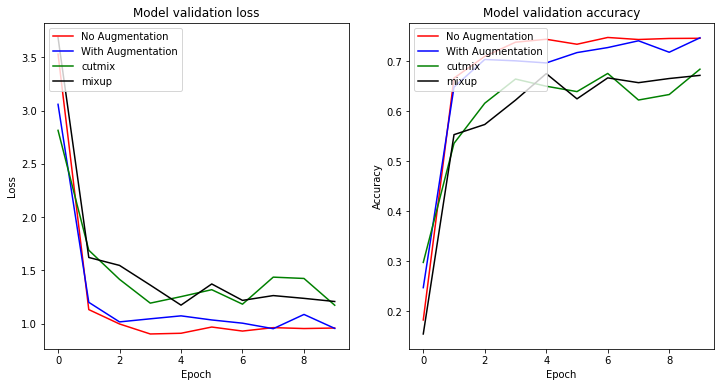

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()

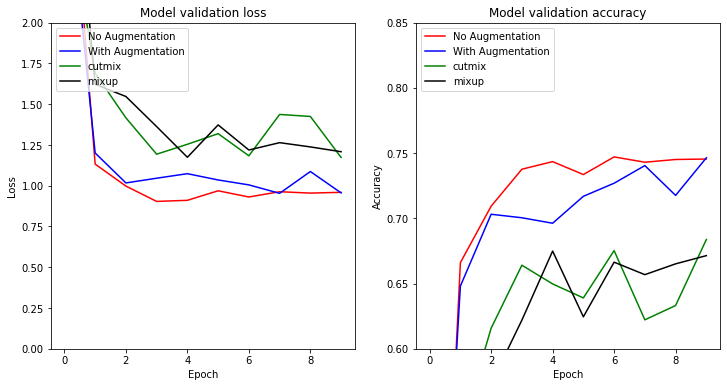

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_ylim([0.00, 2]) # <<<<< 
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_ylim([0.60, 0.85]) # <<<
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()

## 5. Augmentation에 의한 모델 성능 비교